In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(threshold=np.inf)

# Define parameters
class Parameters:
    def __init__(self):
        # Base mutation rate per base pair per year
        self.u = 1.25e-8
        
        # Number of driver positions in each gene
        self.n_APC = 604
        self.n_TP53 = 73
        self.n_KRAS = 20       # why=20???
        
        # Mutation rates per year
        self.r_APC = self.n_APC * self.u
        self.r_TP53 = self.n_TP53 * self.u
        self.r_KRAS = self.n_KRAS * self.u
        self.r_LOH = 1.36e-4
        
        # Growth rates per year
        self.b_APC = 0.2    # APC-/- growth rate
        self.b_KRAS = 0.07  # KRAS+ growth rate
        self.b_BOTH = 0.27  # Combined APC-/-,KRAS+ growth rate
        
        # Initial number of crypts
        self.N_crypts = 10**8

        # Correction factors
        self.c1 = 5.88  # APC fixation advantage
        self.c2 = 3.6   # KRAS fixation advantage
        self.c = self.c1 * self.c2  # Combined correction

In [9]:
# Matrix Method
def create_transition_matrix(params):
    """Create 32x32 transition rate matrix"""
    n = 32
    T = np.zeros((n, n))
    
    def state_to_idx(apc, tp53, kras):
        return apc * 8 + tp53 * 2 + kras
    
    # APC transitions
    for tp53 in range(4):
        for kras in range(2):
            # APC: (0) -> (1) or (2)
            T[state_to_idx(0, tp53, kras), state_to_idx(1, tp53, kras)] = params.r_LOH
            T[state_to_idx(0, tp53, kras), state_to_idx(2, tp53, kras)] = params.r_APC
            
            # APC: (1) -> (3)
            T[state_to_idx(1, tp53, kras), state_to_idx(3, tp53, kras)] = params.r_APC/2
            
            # APC: (2) -> (3)
            T[state_to_idx(2, tp53, kras), state_to_idx(3, tp53, kras)] = params.r_LOH/2
    
    # TP53 transitions
    for apc in range(4):
        for kras in range(2):
            # TP53: (0) -> (1) or (2)
            T[state_to_idx(apc, 0, kras), state_to_idx(apc, 1, kras)] = params.r_LOH
            T[state_to_idx(apc, 0, kras), state_to_idx(apc, 2, kras)] = params.r_TP53
            
            # TP53: (1) -> (3)
            T[state_to_idx(apc, 1, kras), state_to_idx(apc, 3, kras)] = params.r_TP53/2
            
            # TP53: (2) -> (3)
            T[state_to_idx(apc, 2, kras), state_to_idx(apc, 3, kras)] = params.r_LOH/2
    
    # KRAS transitions
    for apc in range(4):
        for tp53 in range(4):
            # KRAS: (0) -> (1)
            T[state_to_idx(apc, tp53, 0), state_to_idx(apc, tp53, 1)] = params.r_KRAS
            
    return T

In [10]:
def create_growth_matrix(params):
    """Create 32x32 diagonal growth rate matrix"""
    n = 32
    G = np.zeros((n, n))
    
    def state_to_idx(apc, tp53, kras):
        return apc * 8 + tp53 * 2 + kras
    
    # Fill diagonal with growth rates
    for apc in range(4):
        for tp53 in range(4):
            for kras in range(2):
                idx = state_to_idx(apc, tp53, kras)
                
                if apc >= 3:  # APC-/- states
                    if kras == 1:  # APC-/- + KRAS+
                        G[idx, idx] = params.b_BOTH
                    else:  # Only APC-/-
                        G[idx, idx] = params.b_APC
                elif kras == 1:  # KRAS+ only
                    G[idx, idx] = params.b_KRAS
                
    return G

def simulate_evolution(params, t_max=80, dt=0.1):
    """Simulate the evolution of crypts using matrix approach"""
    # Create matrices
    T = create_transition_matrix(params)
    G = create_growth_matrix(params)
    
    # # Output the transition matrix T and growth matrix G
    # print("Transition Matrix (T):")
    # print(T)
    # print("\nGrowth Matrix (G):")
    # print(G)
    
    # Time points
    times = np.arange(0, t_max + dt, dt)
    
    # Initialize state vector (all crypts in state 000)
    v = np.zeros(32)
    v[0] = params.N_crypts
    
    # Store results
    results = np.zeros(len(times))
    malignant_idx = 3*8 + 3*2 + 1  # Index for state (3,3,1)
    
    # Evolution
    for i, t in enumerate(times):
        # Store malignant probability
        # results[i] = v[malignant_idx] / params.N_crypts
        results[i] = v[malignant_idx] 
        
        # Update state vector
        v = v + (np.matmul(v, T) + np.matmul(v, G)) * dt
        
    return times, results

In [11]:
# equation method
def neutral_solution(t, params):
    """Equation (1): All mutations are neutral"""
    P = (params.N_crypts * params.r_APC * params.r_TP53 * 
         params.r_KRAS * params.r_LOH**2 * t**5) / 4
    return P

def APC_advantage_solution(t, params):
    """Equation (2): Only APC provides growth advantage"""
    P = (3 * params.N_crypts * params.r_APC * params.r_TP53 * 
         params.r_KRAS * params.r_LOH**2 * t**2 * 
         np.exp(params.b_APC * t)) / (2 * params.b_APC**3)
    return P * params.c1

def both_advantage_solution(t, params):
    """Equation (3): Both APC and KRAS provide advantage"""
    b12 = params.b_BOTH
    b1 = params.b_APC
    b2 = params.b_KRAS
    
    P = (params.N_crypts * params.r_APC * params.r_TP53 * 
         params.r_KRAS * params.r_LOH**2 * t * np.exp(b12 * t) * 
         (1/(b12**3 * (b12 - b1)) + 1/(b12**3 * (b12 - b2)) + 
          1/(b12**2 * (b12 - b2)**2)))
    return P * params.c

In [16]:
# Consider tau-leaping data
data1 = pd.read_csv('test1.1.csv', header=None)
data2 = pd.read_csv('test2.1.csv', header=None)

def process_csv(file_name):
    """Read and process a CSV file to calculate cancer probabilities."""
    df = file_name
    years = df[0]
    state_331 = df[38]  # (3,3,1) state
    state_341 = df[40]  # (3,4,1) state
    state_431 = df[48]  # (4,3,1) state
    state_441 = df[50]  # (4,4,1) state
    cancer_prob = state_331 + state_341 + state_431 + state_441
    print(cancer_prob)
    return years, cancer_prob

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
        ...   
76    0.002296
77    0.002838
78    0.003503
79    0.004324
80    0.005385
Length: 81, dtype: float64
0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
        ...   
76    0.000066
77    0.000081
78    0.000106
79    0.000129
80    0.000154
Length: 81, dtype: float64


/var/folders/rq/d1f380z1435dgk98n9b9hwz40000gn/T/ipykernel_11796/3113238378.py:105: RuntimeWarning: invalid value encountered in divide
  diff_neutral = (P_matrix_neutral - P_neutral_interp)/P_neutral_interp
/var/folders/rq/d1f380z1435dgk98n9b9hwz40000gn/T/ipykernel_11796/3113238378.py:106: RuntimeWarning: invalid value encountered in divide
  diff_APC = (P_matrix_APC - P_APC_interp)/P_APC_interp
/var/folders/rq/d1f380z1435dgk98n9b9hwz40000gn/T/ipykernel_11796/3113238378.py:107: RuntimeWarning: invalid value encountered in divide
  diff_both = (P_matrix_both - P_both_interp)/P_both_interp


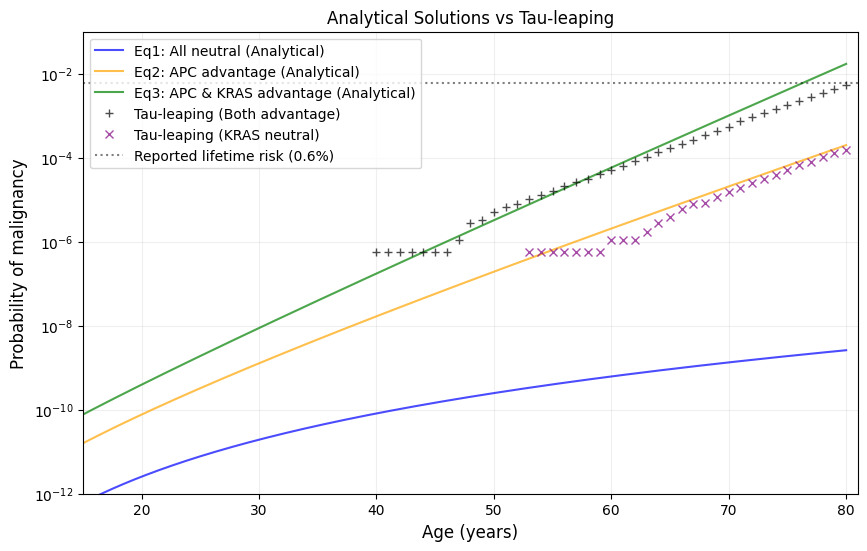

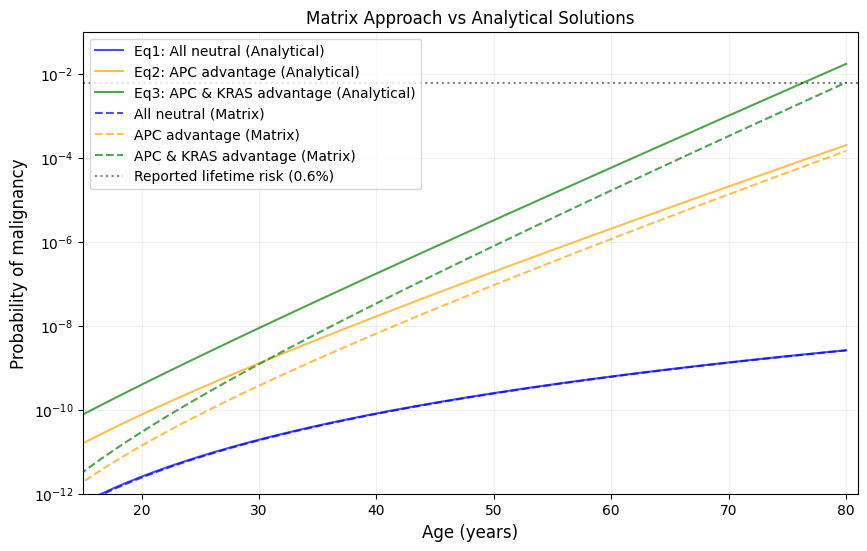

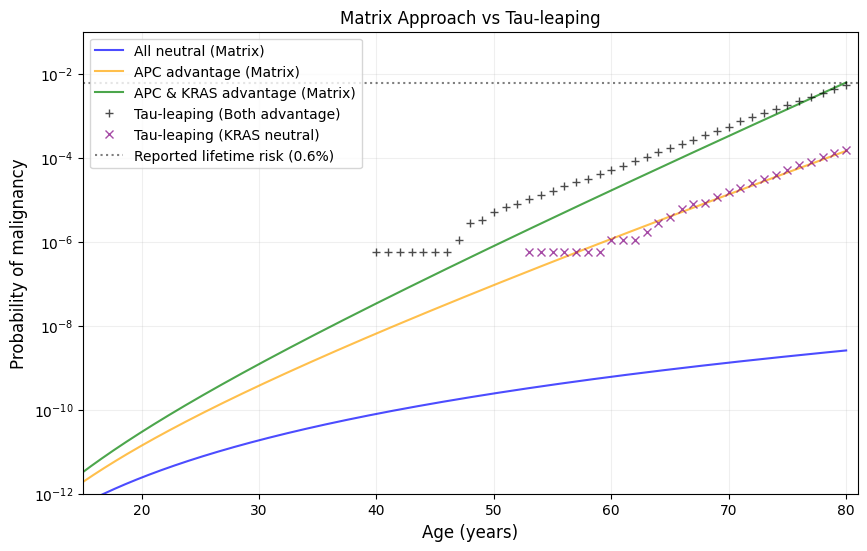

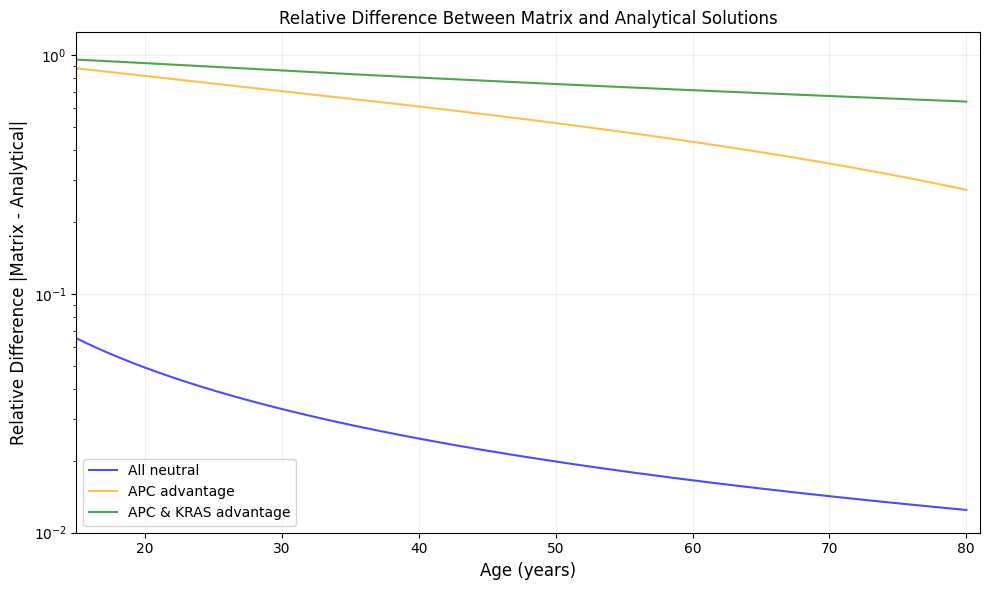

In [17]:
# plot
def plot_comparisons():
    """Create all three comparison plots"""
    params = Parameters()
    t = np.linspace(0, 80, 801)  # 0.1 year steps for analytical solutions
    
    # Calculate analytical solutions
    P_neutral = neutral_solution(t, params)
    P_APC = APC_advantage_solution(t, params)
    P_both = both_advantage_solution(t, params)
    
    params_neutral = Parameters()
    params_neutral.b_APC = 0
    params_neutral.b_KRAS = 0
    params_neutral.b_BOTH = 0

    params_APC = Parameters()
    params_APC.b_APC = 0.2
    params_APC.b_KRAS = 0
    params_APC.b_BOTH = 0.2

    # Calculate matrix solutions
    t_matrix, P_matrix_neutral = simulate_evolution(params_neutral, t_max=80, dt=0.1)
    t_matrix, P_matrix_APC = simulate_evolution(params_APC, t_max=80, dt=0.1)
    t_matrix, P_matrix_both = simulate_evolution(params, t_max=80, dt=0.1)
    
    # Load tau-leaping data
    t_tau1, P_tau1 = process_csv(data1)  # Both advantage
    t_tau2, P_tau2 = process_csv(data2)  # KRAS neutral

    # Create three plots
    fig_size = (10, 6)
    font_size = 12
    
    # Plot 1: Analytical equations vs tau-leaping
    plt.figure(figsize=fig_size)
    plt.semilogy(t, P_neutral, 'b-', label='Eq1: All neutral (Analytical)', alpha=0.7)
    plt.semilogy(t, P_APC, 'orange', label='Eq2: APC advantage (Analytical)', alpha=0.7)
    plt.semilogy(t, P_both, 'g-', label='Eq3: APC & KRAS advantage (Analytical)', alpha=0.7)
    # plt.semilogy(t_tau1, P_tau1, 'k.', label='Tau-leaping (Both advantage)', alpha=0.5, markersize=2)
    # plt.semilogy(t_tau2, P_tau2, 'b.', label='Tau-leaping (KRAS neutral)', alpha=0.5, markersize=2)
    plt.semilogy(t_tau1, P_tau1, 'k+', label='Tau-leaping (Both advantage)', alpha=0.7, markersize=6)
    plt.semilogy(t_tau2, P_tau2, 'x', color='purple', label='Tau-leaping (KRAS neutral)', alpha=0.7, markersize=6)

    plt.axhline(y=0.006, color='k', linestyle=':', alpha=0.5, label='Reported lifetime risk (0.6%)')
    plt.xlabel('Age (years)', fontsize=font_size)
    plt.ylabel('Probability of malignancy', fontsize=font_size)
    plt.title('Analytical Solutions vs Tau-leaping', fontsize=font_size)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(fontsize=font_size-2)
    plt.ylim(1e-12, 1e-1)
    plt.xlim(15, 81)
    
    # Plot 2: Matrix approach vs analytical equations
    plt.figure(figsize=fig_size)
    plt.semilogy(t, P_neutral, 'b-', label='Eq1: All neutral (Analytical)', alpha=0.7)
    plt.semilogy(t, P_APC, 'orange', label='Eq2: APC advantage (Analytical)', alpha=0.7)
    plt.semilogy(t, P_both, 'g-', label='Eq3: APC & KRAS advantage (Analytical)', alpha=0.7)
    plt.semilogy(t_matrix, P_matrix_neutral, 'b--', label='All neutral (Matrix)', alpha=0.7)
    # plt.semilogy(t_matrix, P_matrix_APC, 'orange', label='APC advantage (Matrix)', alpha=0.7)
    plt.semilogy(t_matrix, P_matrix_APC, '--', color='orange', label='APC advantage (Matrix)', alpha=0.7)
    plt.semilogy(t_matrix, P_matrix_both, 'g--', label='APC & KRAS advantage (Matrix)', alpha=0.7)
    plt.axhline(y=0.006, color='k', linestyle=':', alpha=0.5, label='Reported lifetime risk (0.6%)')
    plt.xlabel('Age (years)', fontsize=font_size)
    plt.ylabel('Probability of malignancy', fontsize=font_size)
    plt.title('Matrix Approach vs Analytical Solutions', fontsize=font_size)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(fontsize=font_size-2)
    plt.ylim(1e-12, 1e-1)
    plt.xlim(15, 81)
    
    # Plot 3: Matrix approach vs tau-leaping
    plt.figure(figsize=fig_size)
    plt.semilogy(t_matrix, P_matrix_neutral, 'b-', label='All neutral (Matrix)', alpha=0.7)
    plt.semilogy(t_matrix, P_matrix_APC, 'orange', label='APC advantage (Matrix)', alpha=0.7)
    plt.semilogy(t_matrix, P_matrix_both, 'g-', label='APC & KRAS advantage (Matrix)', alpha=0.7)
    # plt.semilogy(t_tau1, P_tau1, 'k+', label='Tau-leaping (Both advantage)', alpha=0.5, markersize=2)
    # plt.semilogy(t_tau2, P_tau2, 'bx', label='Tau-leaping (KRAS neutral)', alpha=0.5, markersize=2)


    plt.semilogy(t_tau1, P_tau1, 'k+', label='Tau-leaping (Both advantage)', alpha=0.7, markersize=6)
    plt.semilogy(t_tau2, P_tau2, 'x', color='purple', label='Tau-leaping (KRAS neutral)', alpha=0.7, markersize=6)


    plt.axhline(y=0.006, color='k', linestyle=':', alpha=0.5, label='Reported lifetime risk (0.6%)')
    plt.xlabel('Age (years)', fontsize=font_size)
    plt.ylabel('Probability of malignancy', fontsize=font_size)
    plt.title('Matrix Approach vs Tau-leaping', fontsize=font_size)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(fontsize=font_size-2)
    plt.ylim(1e-12, 1e-1)
    plt.xlim(15, 81)

    # Plot 4: Difference between Matrix approach and Equation 
    from scipy.interpolate import interp1d
    f_neutral = interp1d(t, P_neutral)
    f_APC = interp1d(t, P_APC)
    f_both = interp1d(t, P_both)
    
    P_neutral_interp = f_neutral(t_matrix)
    P_APC_interp = f_APC(t_matrix)
    P_both_interp = f_both(t_matrix)
    
    # Calculate absolute differences
    diff_neutral = (P_matrix_neutral - P_neutral_interp)/P_neutral_interp
    diff_APC = (P_matrix_APC - P_APC_interp)/P_APC_interp
    diff_both = (P_matrix_both - P_both_interp)/P_both_interp
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.semilogy(t_matrix, np.abs(diff_neutral), 'b-', label='All neutral', alpha=0.7)
    plt.semilogy(t_matrix, np.abs(diff_APC), 'orange', label='APC advantage', alpha=0.7)
    plt.semilogy(t_matrix, np.abs(diff_both), 'g-', label='APC & KRAS advantage', alpha=0.7)
    
    plt.xlabel('Age (years)', fontsize=12)
    plt.ylabel('Relative Difference |Matrix - Analytical|', fontsize=12)
    plt.title('Relative Difference Between Matrix and Analytical Solutions', fontsize=12)
    plt.grid(True, alpha=0.2)
    plt.legend(fontsize=10)
    plt.xlim(15, 81)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_comparisons()

In [7]:
def plot_comparisons():
    """Create all four comparison plots and save them as PDF files."""
    params = Parameters()
    t = np.linspace(0, 80, 801)  # 0.1 year steps for analytical solutions
    
    # Calculate analytical solutions
    P_neutral = neutral_solution(t, params)
    P_APC = APC_advantage_solution(t, params)
    P_both = both_advantage_solution(t, params)
    
    params_neutral = Parameters()
    params_neutral.b_APC = 0
    params_neutral.b_KRAS = 0
    params_neutral.b_BOTH = 0

    params_APC = Parameters()
    params_APC.b_APC = 0.2
    params_APC.b_KRAS = 0
    params_APC.b_BOTH = 0.2

    # Calculate matrix solutions
    t_matrix, P_matrix_neutral = simulate_evolution(params_neutral, t_max=80, dt=0.1)
    t_matrix, P_matrix_APC = simulate_evolution(params_APC, t_max=80, dt=0.1)
    t_matrix, P_matrix_both = simulate_evolution(params, t_max=80, dt=0.1)
    
    # Load tau-leaping data
    t_tau1, P_tau1 = process_csv(data1)  # Both advantage
    t_tau2, P_tau2 = process_csv(data2)  # KRAS neutral

    # Plot 1: Analytical equations vs tau-leaping
    plt.figure(figsize=(10, 6))
    plt.semilogy(t, P_neutral, 'b-', label='Eq1: All neutral (Analytical)', alpha=0.7)
    plt.semilogy(t, P_APC, 'orange', label='Eq2: APC advantage (Analytical)', alpha=0.7)
    plt.semilogy(t, P_both, 'g-', label='Eq3: APC & KRAS advantage (Analytical)', alpha=0.7)
    plt.semilogy(t_tau1, P_tau1, 'k+', label='Tau-leaping (Both advantage)', alpha=0.7, markersize=6)
    plt.semilogy(t_tau2, P_tau2, 'x', color='purple', label='Tau-leaping (KRAS neutral)', alpha=0.7, markersize=6)
    plt.axhline(y=0.006, color='k', linestyle=':', alpha=0.5, label='Reported lifetime risk (0.6%)')
    plt.xlabel('Age (years)', fontsize=12)
    plt.ylabel('Probability of malignancy', fontsize=12)
    plt.title('Analytical Solutions vs Tau-leaping', fontsize=12)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(fontsize=10)
    plt.ylim(1e-12, 1e-1)
    plt.xlim(15, 81)
    plt.tight_layout()
    plt.savefig("plot_analytical_vs_taueleaping.pdf")
    plt.close()

    # Plot 2: Matrix approach vs analytical equations
    plt.figure(figsize=(10, 6))
    plt.semilogy(t, P_neutral, 'b-', label='Eq1: All neutral (Analytical)', alpha=0.7)
    plt.semilogy(t, P_APC, 'orange', label='Eq2: APC advantage (Analytical)', alpha=0.7)
    plt.semilogy(t, P_both, 'g-', label='Eq3: APC & KRAS advantage (Analytical)', alpha=0.7)
    plt.semilogy(t_matrix, P_matrix_neutral, 'b--', label='All neutral (Matrix)', alpha=0.7)
    plt.semilogy(t_matrix, P_matrix_APC, '--', color='orange', label='APC advantage (Matrix)', alpha=0.7)
    plt.semilogy(t_matrix, P_matrix_both, 'g--', label='APC & KRAS advantage (Matrix)', alpha=0.7)
    plt.axhline(y=0.006, color='k', linestyle=':', alpha=0.5, label='Reported lifetime risk (0.6%)')
    plt.xlabel('Age (years)', fontsize=12)
    plt.ylabel('Probability of malignancy', fontsize=12)
    plt.title('Matrix Approach vs Analytical Solutions', fontsize=12)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(fontsize=10)
    plt.ylim(1e-12, 1e-1)
    plt.xlim(15, 81)
    plt.tight_layout()
    plt.savefig("plot_matrix_vs_analytical.pdf")
    plt.close()

    # Plot 3: Matrix approach vs tau-leaping
    plt.figure(figsize=(10, 6))
    plt.semilogy(t_matrix, P_matrix_neutral, 'b-', label='All neutral (Matrix)', alpha=0.7)
    plt.semilogy(t_matrix, P_matrix_APC, 'orange', label='APC advantage (Matrix)', alpha=0.7)
    plt.semilogy(t_matrix, P_matrix_both, 'g-', label='APC & KRAS advantage (Matrix)', alpha=0.7)
    plt.semilogy(t_tau1, P_tau1, 'k+', label='Tau-leaping (Both advantage)', alpha=0.7, markersize=6)
    plt.semilogy(t_tau2, P_tau2, 'x', color='purple', label='Tau-leaping (KRAS neutral)', alpha=0.7, markersize=6)
    plt.axhline(y=0.006, color='k', linestyle=':', alpha=0.5, label='Reported lifetime risk (0.6%)')
    plt.xlabel('Age (years)', fontsize=12)
    plt.ylabel('Probability of malignancy', fontsize=12)
    plt.title('Matrix Approach vs Tau-leaping', fontsize=12)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(fontsize=10)
    plt.ylim(1e-12, 1e-1)
    plt.xlim(15, 81)
    plt.tight_layout()
    plt.savefig("plot_matrix_vs_taueleaping.pdf")
    plt.close()

    # Plot 4: Relative difference between Matrix and Analytical Solutions
    from scipy.interpolate import interp1d
    f_neutral = interp1d(t, P_neutral)
    f_APC = interp1d(t, P_APC)
    f_both = interp1d(t, P_both)
    
    P_neutral_interp = f_neutral(t_matrix)
    P_APC_interp = f_APC(t_matrix)
    P_both_interp = f_both(t_matrix)
    
    # Calculate relative differences
    diff_neutral = (P_matrix_neutral - P_neutral_interp) / P_neutral_interp
    diff_APC = (P_matrix_APC - P_APC_interp) / P_APC_interp
    diff_both = (P_matrix_both - P_both_interp) / P_both_interp
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(t_matrix, np.abs(diff_neutral), 'b-', label='All neutral', alpha=0.7)
    plt.semilogy(t_matrix, np.abs(diff_APC), 'orange', label='APC advantage', alpha=0.7)
    plt.semilogy(t_matrix, np.abs(diff_both), 'g-', label='APC & KRAS advantage', alpha=0.7)
    plt.xlabel('Age (years)', fontsize=12)
    plt.ylabel('Relative Difference |Matrix - Analytical|', fontsize=12)
    plt.title('Relative Difference Between Matrix and Analytical Solutions', fontsize=12)
    plt.grid(True, alpha=0.2)
    plt.legend(fontsize=10)
    plt.xlim(15, 81)
    plt.tight_layout()
    plt.savefig("plot_relative_difference.pdf")
    plt.close()

    # Notify completion
    print("All plots saved as PDF files.")

if __name__ == "__main__":
    plot_comparisons()


/var/folders/rq/d1f380z1435dgk98n9b9hwz40000gn/T/ipykernel_11796/3158675895.py:99: RuntimeWarning: invalid value encountered in divide
  diff_neutral = (P_matrix_neutral - P_neutral_interp) / P_neutral_interp
/var/folders/rq/d1f380z1435dgk98n9b9hwz40000gn/T/ipykernel_11796/3158675895.py:100: RuntimeWarning: invalid value encountered in divide
  diff_APC = (P_matrix_APC - P_APC_interp) / P_APC_interp
/var/folders/rq/d1f380z1435dgk98n9b9hwz40000gn/T/ipykernel_11796/3158675895.py:101: RuntimeWarning: invalid value encountered in divide
  diff_both = (P_matrix_both - P_both_interp) / P_both_interp


All plots saved as PDF files.
